In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/14986.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/3138.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/1700.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/16257.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/2863.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/771.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/12167.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/17643.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/6560.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/10162.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/4009.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/15823.jpg
/kaggle/input/intel-image-classification/seg_tr

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import load_img, img_to_array
import cv2
import keras
from tensorflow.keras.models import Sequential, Model

2025-09-26 11:26:32.926329: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758885993.124600      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758885993.181520      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Gerekli kütüphanelerin import edilmesi. 

* Pandas ve Numpy veri setleri için
* Matplotlib ve seaborn görselleştirme için
* Tensorflow ve Keras CNN modeli oluşturma için
* sklearn.metrics modelin değerlendirilmesi için import edildi.

In [3]:
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32
trainpath = '/kaggle/input/intel-image-classification/seg_train/seg_train'
testpath = '/kaggle/input/intel-image-classification/seg_test/seg_test'
predpath = '/kaggle/input/intel-image-classification/seg_pred/seg_pred'

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  trainpath,
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

test_ds = tf.keras.utils.image_dataset_from_directory(
  testpath,
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

Found 14034 files belonging to 6 classes.


I0000 00:00:1758886006.960997      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 3000 files belonging to 6 classes.


Veri setlerinin eğitim ve test olarak içeri alınması.

In [5]:
class_names = train_ds.class_names
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


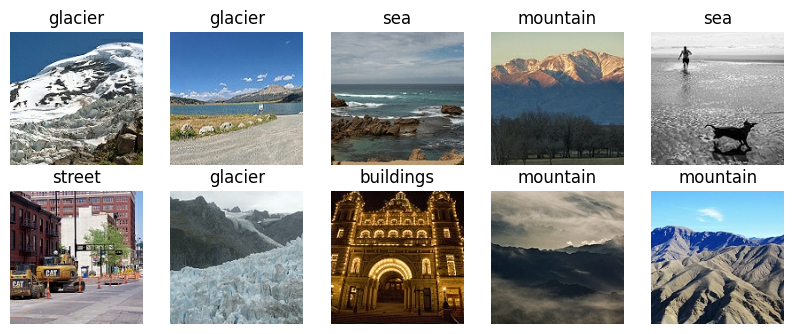

In [6]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(3):
    for i in range(10):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i+20].numpy().astype("uint8"))
        plt.title(class_names[labels[i+20]])
        plt.axis("off")

Eğitim verilerinden bazı örnek resimlerin görselleştirilmesi

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


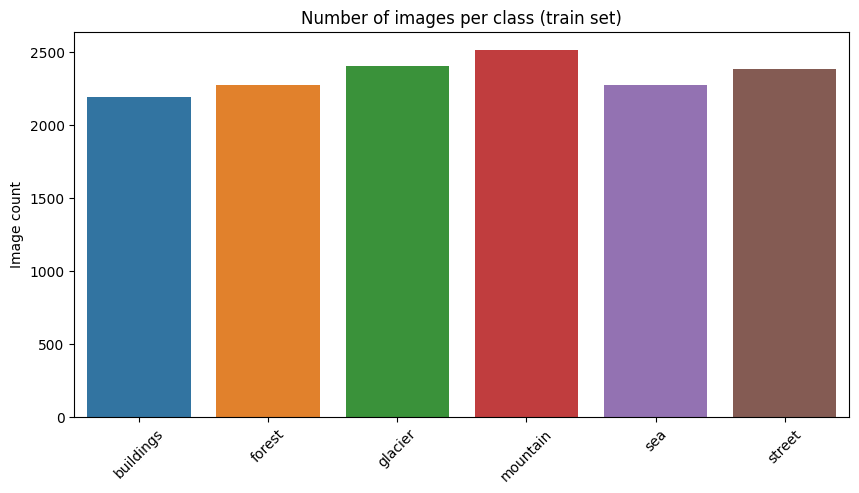

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


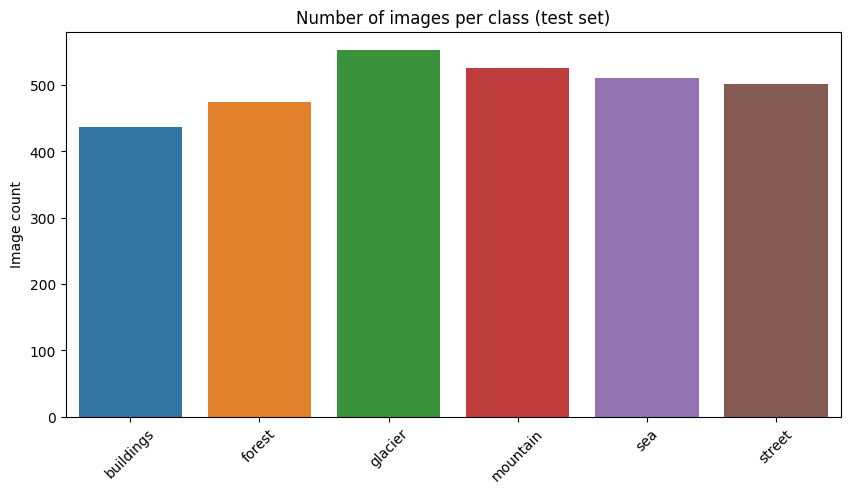

In [7]:
class_counts = {cls: len(os.listdir(os.path.join(trainpath, cls))) for cls in class_names}

plt.figure(figsize=(10,5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=45)
plt.title("Number of images per class (train set)")
plt.ylabel("Image count")
plt.show()

class_counts = {cls: len(os.listdir(os.path.join(testpath, cls))) for cls in class_names}

plt.figure(figsize=(10,5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=45)
plt.title("Number of images per class (test set)")
plt.ylabel("Image count")
plt.show()

Datasetlerinde bulunan verilerin sınıflara göre dağılımı. Sınıflarda bulunan veri sayılarının yakın düzeyde olduğu görüldü.

In [8]:

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

model = keras.Sequential([
    keras.Input(shape=(150, 150, 3)), 

    data_augmentation,                 
    layers.Rescaling(1./255),         

    layers.Conv2D(32, (3,3), activation='relu', padding="same"),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu', padding="same"),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu', padding="same"),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),              
    layers.Dense(6, activation='softmax')  
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  
    metrics=['accuracy']
)

In [9]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    10,617,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,711,878 (40.86 MB)

 Trainable params: 10,711,878 (40.86 MB)

 Non-trainable params: 0 (0.00 B)

CNN modelinin tanımlanması.

Modelin overfitting etmesini önlemek için içine augmentation katmanı eklendi.

Modelde 3 adet conv layer ve maxpool katmanı kullanıldı.

Model compile edilerek eğitim için hazır hale getirildi.

En sonda modelin özet grafiği görülebilir

In [10]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20
)

Epoch 1/20


I0000 00:00:1758886016.941513      66 cuda_dnn.cc:529] Loaded cuDNN version 90300


439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.3748 - loss: 1.5166 - val_accuracy: 0.4870 - val_loss: 1.2709
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.5391 - loss: 1.1737 - val_accuracy: 0.5743 - val_loss: 1.0789
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.5770 - loss: 1.1156 - val_accuracy: 0.6400 - val_loss: 0.9881
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.6047 - loss: 1.0485 - val_accuracy: 0.6073 - val_loss: 1.1846
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.6269 - loss: 0.9979 - val_accuracy: 0.6570 - val_loss: 0.9604
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.6498 - loss: 0.9453 - val_accuracy: 0.6540 - val_loss: 0.9565
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.6603 - loss: 0.9319 - val_accuracy: 0.7003 - val_loss: 0.8277
Epoch 8/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.6643 - loss: 0.9023 - val_accurac

Modellin train_ds üzerinde eğitilmesi

In [11]:
loss, accuracy = model.evaluate(train_ds)
print(f'Train accuracy: {accuracy * 100:.2f}%')

439/439 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7627 - loss: 0.6620
Train accuracy: 76.47%


In [12]:
loss, accuracy = model.evaluate(test_ds)
print(f'Train accuracy: {accuracy * 100:.2f}%')

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7408 - loss: 0.7111
Train accuracy: 73.67%


Modelin Train verisi üzerinde doğruluk oranının gösterilmesi.

In [13]:
def evaluate_model(model, dataset, class_names):
    # Evaluate overall loss & accuracy
    loss, accuracy = model.evaluate(dataset, verbose=0)
    print(f'Test accuracy: {accuracy * 100:.2f}%\n')

    # Collect predictions and true labels
    y_true, y_pred = [], []

    for batch_x, batch_y in dataset:
        preds = np.argmax(model.predict(batch_x, verbose=0), axis=1)
        y_pred.extend(preds)
        y_true.extend(batch_y.numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Classification report
    print("Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

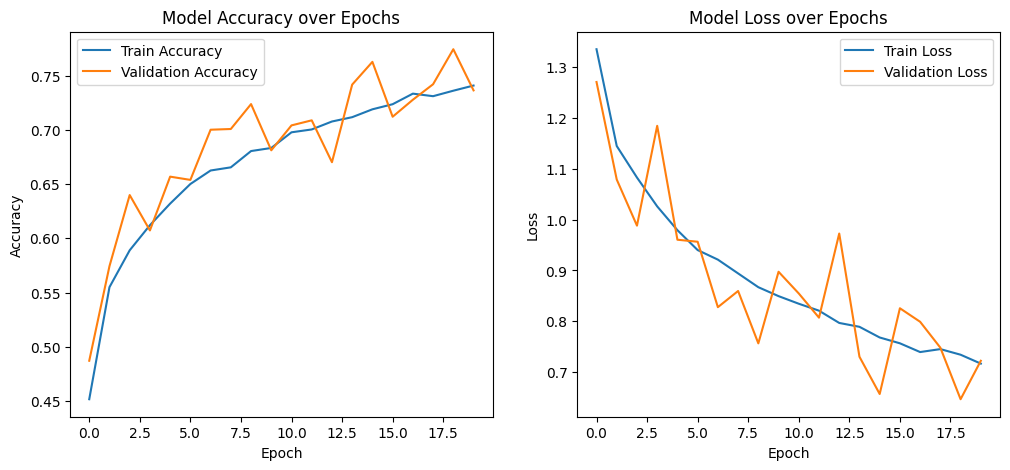

In [14]:
plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Modelin 20 Epoch boyunca accuracy ve loss grafiklerinin gösterilmesi.

Test accuracy: 73.67%

Classification Report:

              precision    recall  f1-score   support

   buildings       0.62      0.62      0.62       437
      forest       0.92      0.97      0.94       474
     glacier       0.84      0.59      0.70       553
    mountain       0.81      0.58      0.68       525
         sea       0.66      0.77      0.71       510
      street       0.64      0.90      0.75       501

    accuracy                           0.74      3000
   macro avg       0.75      0.74      0.73      3000
weighted avg       0.75      0.74      0.73      3000



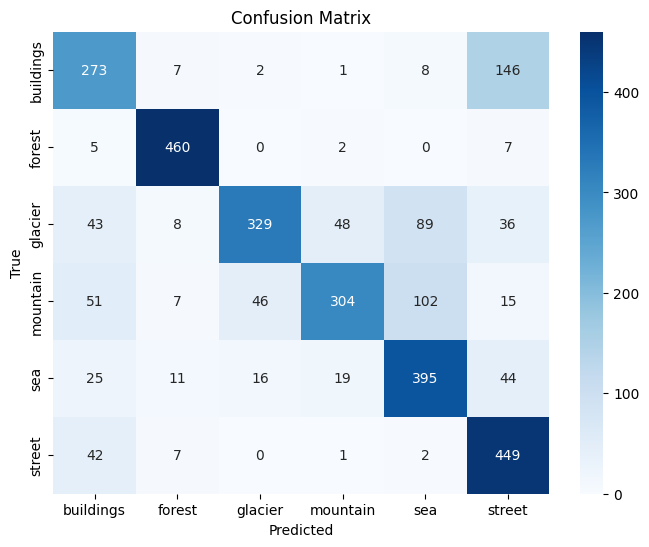

In [15]:
class_names = test_ds.class_names
evaluate_model(model, test_ds, class_names)

Çeşitli metriklerle modelin değerlendirilmesi. Confusion matrixte görülene göre görünüşü yakın cisimleri modelin birbirine karıştırma beklenebilir şekilde daha yüksek. Gracier-Mountain yada Street-Building gibi resimleri model karıştırmış.


Training model with filters=32, learning_rate=0.001
Epoch 1/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.4176 - loss: 1.4026 - val_accuracy: 0.5450 - val_loss: 1.1222
Epoch 2/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.5454 - loss: 1.1586 - val_accuracy: 0.5240 - val_loss: 1.2699
Epoch 3/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.6035 - loss: 1.0550 - val_accuracy: 0.6230 - val_loss: 1.0446
Epoch 4/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.6312 - loss: 0.9856 - val_accuracy: 0.6380 - val_loss: 0.9766
Epoch 5/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.6496 - loss: 0.9361 - val_accuracy: 0.6753 - val_loss: 0.9247

Training model with filters=32, learning_rate=0.0005
Epoch 1/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.3997 - loss: 1.4300 - val_accuracy: 0.5847 - val_loss: 1.1198
Epoch 2/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.5645 - loss: 1.1194 - val_accuracy: 0.6487 - val_los

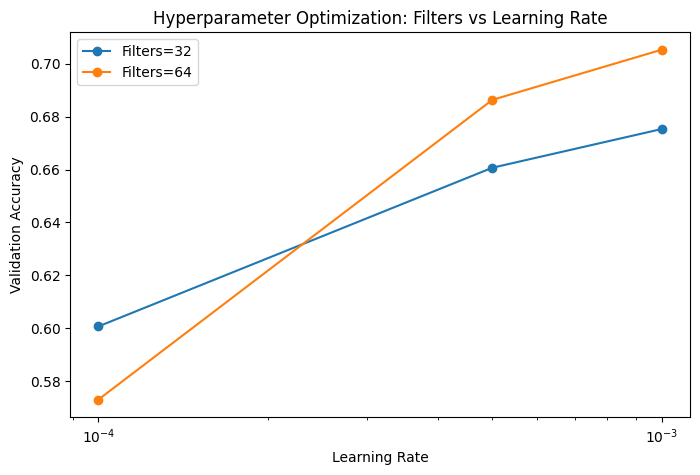

In [16]:
learning_rates = [1e-3, 5e-4, 1e-4]
filter_options = [32, 64] 

results = []

for filters in filter_options:
    for lr in learning_rates:
        print(f"\nTraining model with filters={filters}, learning_rate={lr}")

        model = keras.Sequential([
            keras.Input(shape=(150, 150, 3)),
            data_augmentation,
            layers.Rescaling(1./255),

            layers.Conv2D(filters, (3,3), activation='relu', padding="same"),
            layers.MaxPooling2D(2,2),

            layers.Conv2D(filters*2, (3,3), activation='relu', padding="same"),
            layers.MaxPooling2D(2,2),

            layers.Conv2D(filters*4, (3,3), activation='relu', padding="same"),
            layers.MaxPooling2D(2,2),

            layers.Flatten(),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(6, activation='softmax')
        ])

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=lr),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        history = model.fit(
            train_ds,
            validation_data=test_ds,
            epochs=5,
            verbose=1
        )

        final_val_acc = history.history['val_accuracy'][-1]
        results.append({
            "filters": filters,
            "learning_rate": lr,
            "val_accuracy": final_val_acc
        })

df = pd.DataFrame(results)
print("\nHyperparameter Results:")
print(df)

plt.figure(figsize=(8,5))
for filters in filter_options:
    subset = df[df['filters']==filters]
    plt.plot(subset['learning_rate'], subset['val_accuracy'], marker='o', label=f'Filters={filters}')
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.title('Hyperparameter Optimization: Filters vs Learning Rate')
plt.legend()
plt.show()

Learning rate ve filter oranlarıyla oynayarak buna göre farklı modellerin değerlendirilmesi. Normal modelde 20 Epoch kullanırken burada asıl amaç değişimi göstermek olduğundan 5 epoch kullanıldı.

